## Hotel Booking Analysis

#### Dataset: https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand?datasetId=511638

In [1]:
# Importing necessary modules
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
from sklearn.metrics import mean_squared_error
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set_style("dark")
import tensorflow as tf

## **DATASET LOADING**

**The data set compares various booking information between two hotels: a city hotel and a resort hotel. This dataset is prepared for various city and resort hotels from Lisbon, Portugal.**

In [2]:
# Reading the file
df = pd.read_csv('hotel_bookings.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [4]:
# Statistical Analysis
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


#### COLUMN DEFINITIONS:
Lead time: Timespan between the reservation of a hotel room and checkin

1.   Meal categories: BB (Bed and Breakfast), HB (half board, in which breakfast and dinner are included), FB (full board, in which breakfast, lunch, and dinner are included), SC (self-catering or no meals are included)
2.   Market Segment: Type of booking (Online/Offline travel Agent (TA), Tour Operators (TO), Direct booking or from a Corporate company for business purposes) 
3.   Room types: A, B, C, D, E, F, G, H  (Code of room type reserved. Code is presented instead of designation for anonymity reasons)
4.   ADR: Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights
5.   Total special requests: Number of special requests made by the customer (e.g. twin bed or high floor)

### **DATA CLEANING AND PRE-PROCESSING**

In [5]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [6]:
# Value counts of countries
df['country'].value_counts()

PRT    48590
GBR    12129
FRA    10415
ESP     8568
DEU     7287
       ...  
DJI        1
BWA        1
HND        1
VGB        1
NAM        1
Name: country, Length: 177, dtype: int64

In [7]:
# Dealing with null values
df['agent'] = df['agent'].fillna(0)
df['children'] = df['children'].fillna(0)
df = df.drop('company', axis = 1)

In [8]:
df['country'].fillna('PRT', inplace = True)

In [9]:
df.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces 

## **EXPLORATORY DATA ANALYSIS**

### **Nationwise Distribution of traveller visits to Portugal.**

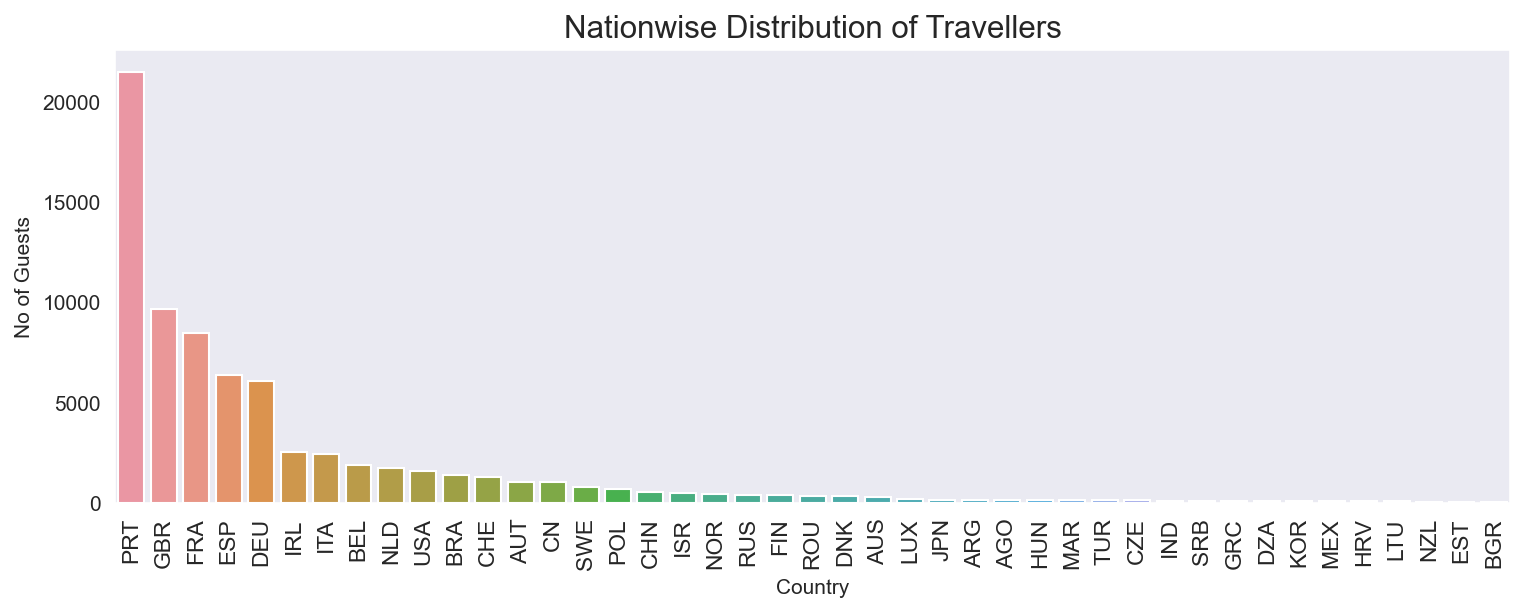

In [10]:
fig = plt.figure(figsize=(12,4), dpi=150)

country_wise_guests = df[(df['is_canceled'] == 0)]['country'].value_counts().reset_index()
country_wise_guests.columns = ['Country', 'No of Guests']
country_wise_guests = country_wise_guests[country_wise_guests['No of Guests'] > 60]

sns.barplot(data=country_wise_guests, x = 'Country', y = 'No of Guests')
plt.xticks(rotation=90,fontsize=11)
plt.title('Nationwise Distribution of Travellers', fontsize=15);

### **Market Segment wise booking Distribution**

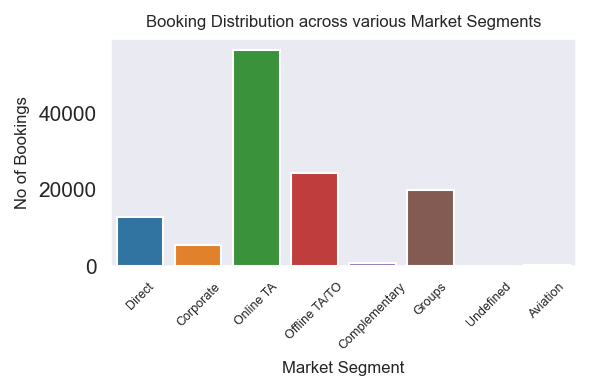

In [11]:
fig = plt.figure(figsize=(4,2), dpi=150)
sns.countplot(data=df, x= 'market_segment')
plt.xlabel('Market Segment', fontsize=8)
plt.xticks(rotation=45,fontsize=6)
plt.ylabel('No of Bookings', fontsize=8)
plt.title('Booking Distribution across various Market Segments', fontsize=8);

In [12]:
df['reserved_room_type'].unique()

array(['C', 'A', 'D', 'E', 'G', 'F', 'H', 'L', 'P', 'B'], dtype=object)

### **Average Daily Rate of Bookings per Hotel type**

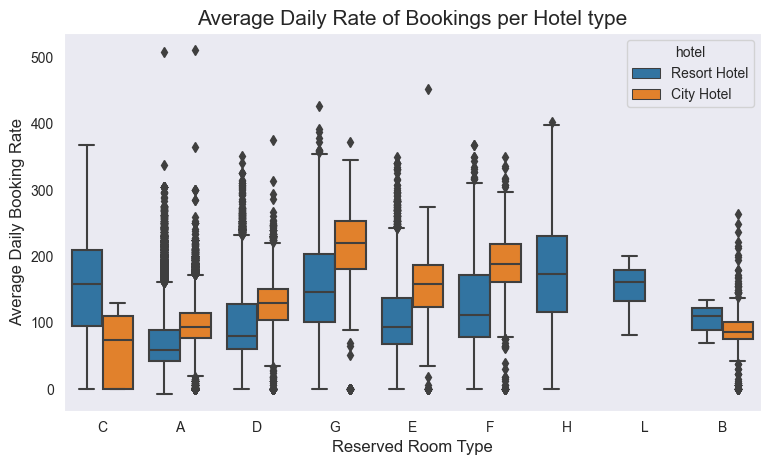

In [13]:
data = df[df['is_canceled'] == 0]
fig = plt.figure(figsize=(9,5), dpi = 100)
sns.boxplot(data= data, x = 'reserved_room_type', y = 'adr', hue = 'hotel')
plt.xlabel('Reserved Room Type', fontsize=12)
plt.ylabel('Average Daily Booking Rate', fontsize=12)
plt.title('Average Daily Rate of Bookings per Hotel type', fontsize=15);

### **Cancellation Count per Hotel Type**

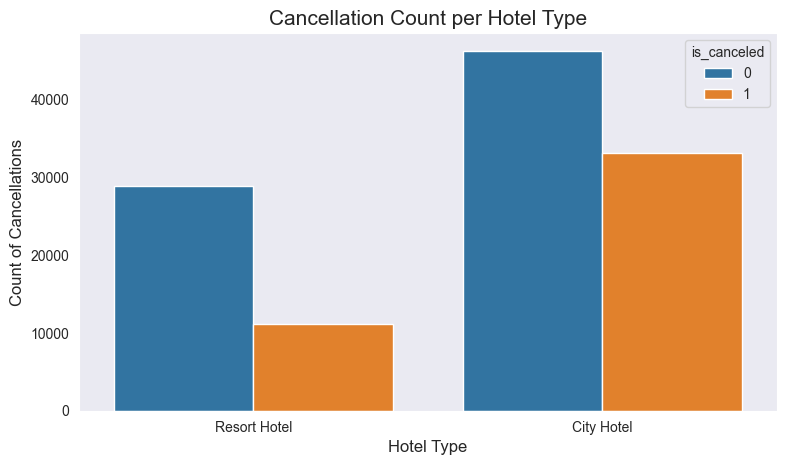

In [14]:
fig = plt.figure(figsize=(9,5), dpi = 100)
sns.countplot(data=df, x = 'hotel', hue='is_canceled')
plt.xlabel('Hotel Type', fontsize=12)
plt.ylabel('Count of Cancellations', fontsize=12)
plt.title('Cancellation Count per Hotel Type', fontsize=15);

## **CORRELATION HEATMAP OF FEATURES:**

<AxesSubplot:>

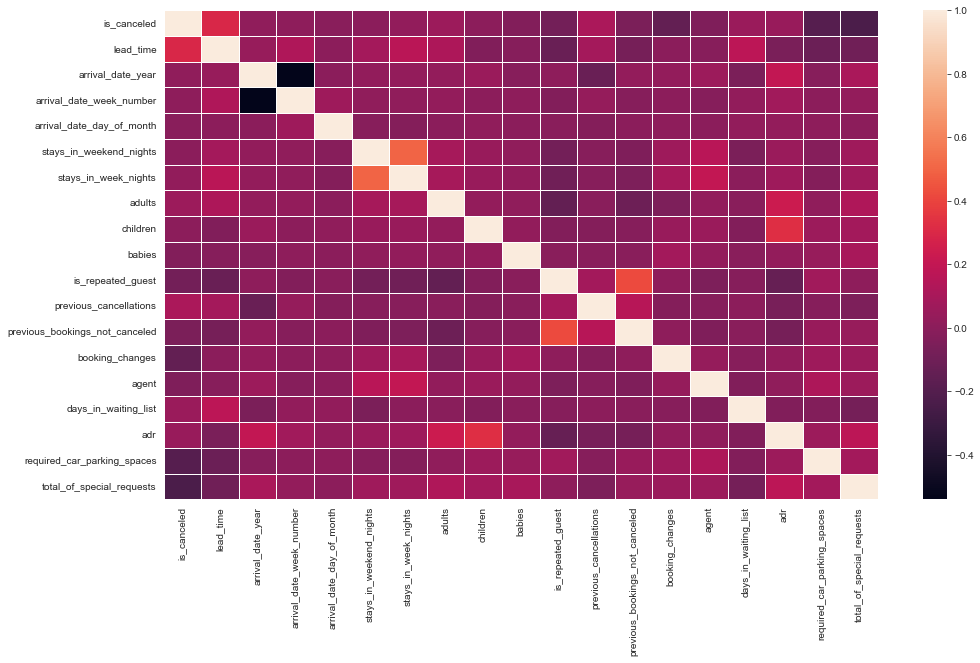

In [15]:
f,ax = plt.subplots(figsize=(16, 9))
plt.xticks(rotation=45,fontsize=10 )
plt.yticks(fontsize=10)
sns.heatmap(df.corr(), linewidths=.5, ax=ax)

## Time Series Analysis

### SARIMA

In [16]:
# Preprocessing and zero-padding
df['arrival_date_week_number'] = df['arrival_date_week_number'].astype('str')

In [17]:
df['arrival_date_week_number'].replace({'1':'01', '2':'02', '3':'03', '4':'04', '5':'05', '6':'06', '7':'07','8':'08','9':'09'}, inplace=True)

In [18]:
c=df.sort_values(['arrival_date_year','arrival_date_week_number'], ascending=True)

In [19]:
c=pd.DataFrame(c)
c

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,3,No Deposit,0.0,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,4,No Deposit,0.0,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,No Deposit,0.0,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,No Deposit,304.0,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,No Deposit,240.0,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,0,No Deposit,394.0,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,0,No Deposit,9.0,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,0,No Deposit,9.0,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,0,No Deposit,89.0,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [20]:
df2 = pd.DataFrame(c, columns= ['arrival_date_year', 'arrival_date_week_number']) 
df2

,arrival_date_year,arrival_date_week_number
0,2015,27
1,2015,27
2,2015,27
3,2015,27
4,2015,27
...,...,...
119385,2017,35
119386,2017,35
119387,2017,35
119388,2017,35


In [21]:
# Joining week number and year
df1 = df2['arrival_date_year'].map(str) + df['arrival_date_week_number'].map(str)
print (df1)
df1=pd.DataFrame(df1)

0         201527
1         201527
2         201527
3         201527
4         201527
           ...  
119385    201735
119386    201735
119387    201735
119388    201735
119389    201735
Length: 119390, dtype: object


In [22]:
df2 = pd.DataFrame(c, columns= ['adr']) 
df2

,adr
0,0.00
1,0.00
2,75.00
3,75.00
4,98.00
...,...
119385,96.14
119386,225.43
119387,157.71
119388,104.40


In [23]:
# Taking ADR for week-year and creating a df
df3=pd.concat([df1, df2], axis = 1)
df3.columns = ['FullDate', 'ADR']

In [24]:
# Taking mean ADR
df4 = df3.groupby('FullDate').agg("mean")
df4
df4.sort_values(['FullDate'], ascending=True)

,ADR
FullDate,
201527,88.979749
201528,92.682701
201529,100.624791
201530,97.159675
201531,113.428325
...,...
201731,164.924514
201732,167.245804
201733,168.947229


In [25]:
tseries=df4['ADR']
tseries = pd.DataFrame(tseries)

In [26]:
tseries

,ADR
FullDate,
201527,88.979749
201528,92.682701
201529,100.624791
201530,97.159675
201531,113.428325
...,...
201731,164.924514
201732,167.245804
201733,168.947229


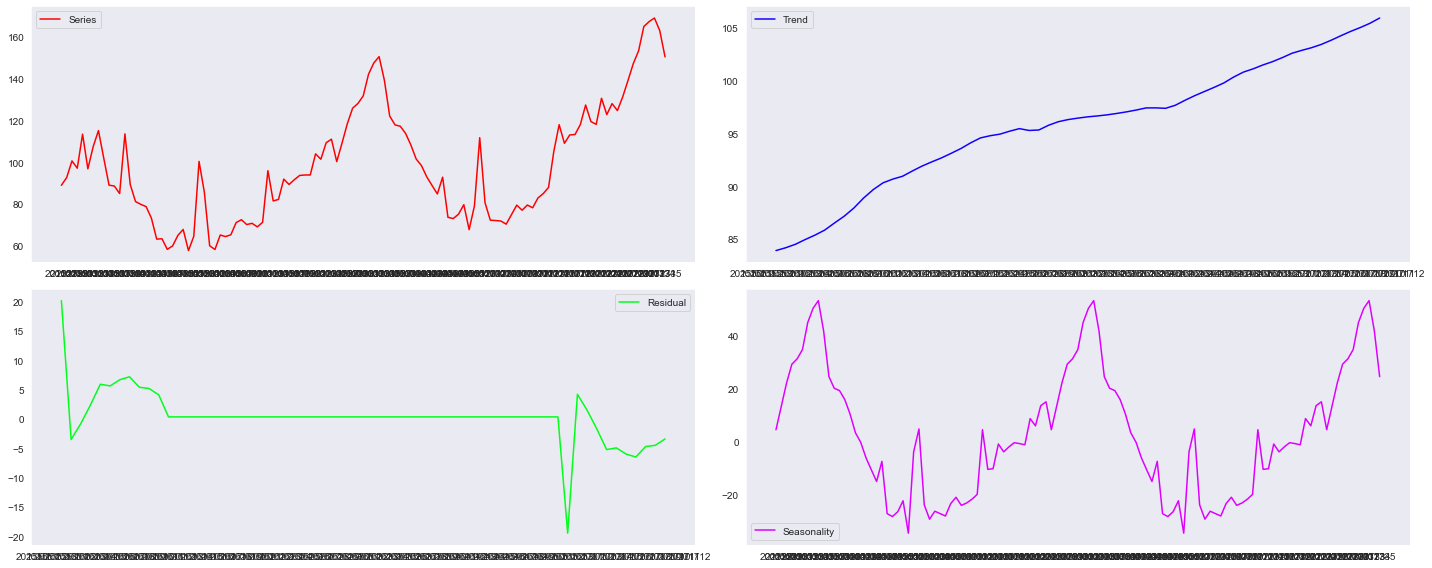

In [27]:
# Decomposition of Data
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition=seasonal_decompose(tseries, model='additive', period=52)
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid
plt.figure(figsize=(20,8))
plt.subplot(221)
plt.plot(tseries,color='#ff0000', label='Series')
plt.legend(loc='best')
plt.subplot(222)
plt.plot(trend,color='#1100ff', label='Trend')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(223)
plt.plot(residual,color='#00ff1a', label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(224)
plt.plot(seasonal,color='#de00ff', label='Seasonality')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

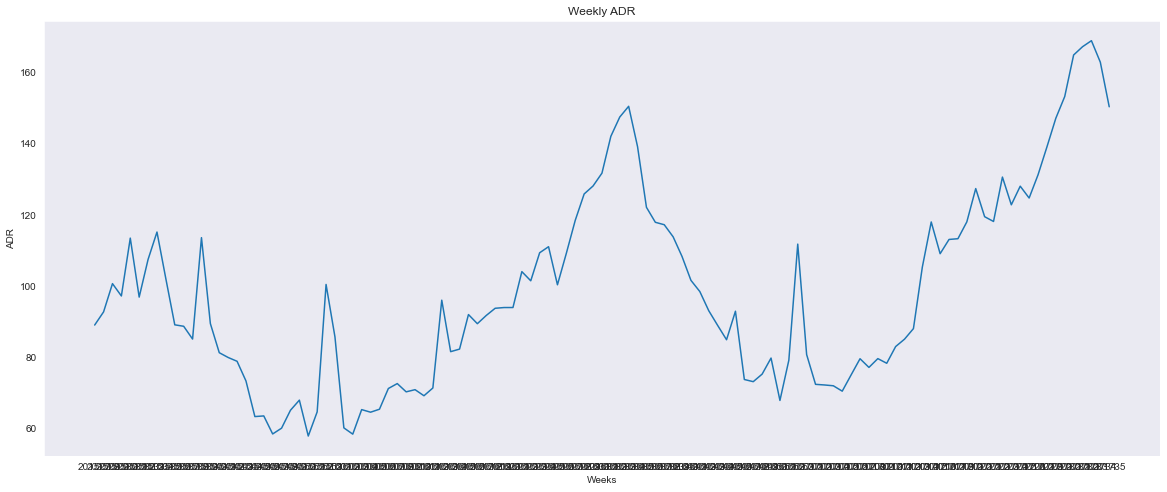

In [28]:
# Train Plot
plt.figure(figsize=(20,8))
plt.plot(tseries)
plt.xlabel('Weeks')
plt.ylabel('ADR')
plt.title("Weekly ADR")
plt.show()

In [29]:
# Train Set
train_df=tseries[:100]
train_df

,ADR
FullDate,
201527,88.979749
201528,92.682701
201529,100.624791
201530,97.159675
201531,113.428325
...,...
201716,109.043531
201717,113.051296
201718,113.261860


In [30]:
# ADF Test
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
from statsmodels.tsa.stattools import adfuller
adf_test(train_df)

ADF Statistics: -1.4035412659518336
p- value: 0.5805772185023568
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


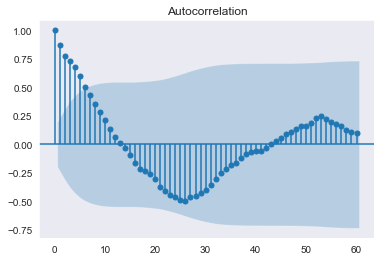

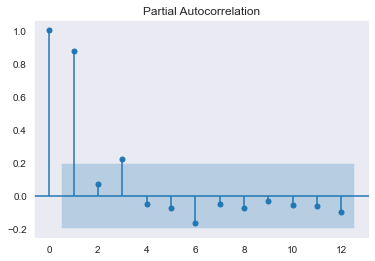

In [31]:
# ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
acf = plot_acf(train_df, lags=60)
pacf = plot_pacf(train_df, lags=12)

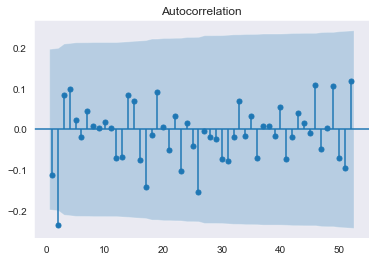

In [32]:
# ACF for differenced data
acf = plot_acf(np.diff(train_df.squeeze(), 1), lags=52, zero=False)

In [33]:
# Test Data
test_df=tseries[100:115]
test_df

,ADR
FullDate,
201721,119.450999
201722,118.106380
201723,130.592753
201724,122.793344
201725,128.033632
201726,124.700541
201727,131.224835
201728,139.069055
201729,147.137428


In [34]:
# Rolling 7 week average
window_size = 7

numbers_series = train_df.squeeze()
windows = numbers_series.rolling(window_size)
moving_averages = windows.mean()

moving_averages_list = moving_averages.tolist()
ts7 = moving_averages_list[window_size - 1:]
ts7=np.array(ts7)

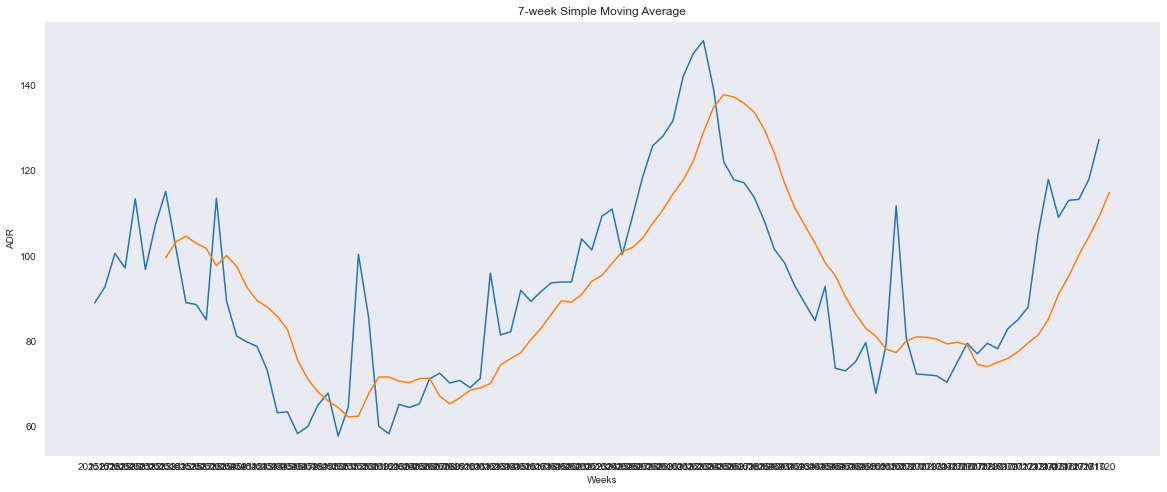

In [35]:
# Plotting 7 week average to smoothen
n1=math.nan
n7=np.array([n1,n1,n1,n1,n1,n1,n1])
ts7=np.concatenate([n7,ts7])
plt.figure(figsize=(20,8))
plt.plot(train_df)
plt.plot(ts7)
plt.xlabel('Weeks')
plt.ylabel('ADR')
plt.title("7-week Simple Moving Average")
plt.show()

In [36]:
# Model Selection
from pmdarima import auto_arima
model_auto_arima = auto_arima(train_df, trace=True, suppress_warnings=True,start_p=0, start_q=0, start_P=0, start_Q=0, max_p=10, max_q=10, max_P=10, max_Q=10, seasonal=True, stepwise=True, d=1, D=1, m=52, max_D=10,error_action='ignore',approximation = False)
fit=model_auto_arima.fit(train_df)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=377.589, Time=0.80 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=2.98 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=2.64 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=2.17 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=inf, Time=2.70 sec
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=381.581, Time=3.10 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=374.975, Time=0.12 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=3.06 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=378.968, Time=3.97 sec
 ARIMA(2,1,0)(0,1,0)[52]             : AIC=372.194, Time=0.16 sec
 ARIMA(2,1,0)(1,1,0)[52]             : AIC=inf, Time=4.15 sec
 ARIMA(2,1,0)(0,1,1)[52]             : AIC=inf, Time=3.46 sec
 ARIMA(2,1,0)(1,1,1)[52]             : AIC=inf, Time=4.81 sec
 ARIMA(3,1,0)(0,1,0)[52]             : AIC=372.565, Time=0.23 sec
 ARIMA(2,1,1)(0,1,0)[52]             : AIC=372.282, Time=0.26 sec

In [37]:
# Model Summary
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  100
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 52)   Log Likelihood                -182.876
Date:                             Sun, 24 Apr 2022   AIC                            369.751
Time:                                     00:58:06   BIC                            373.452
Sample:                                          0   HQIC                           371.144
                                             - 100                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5853      0.098     -5.967      0.000      -0.778      -0.393
sigma2       139.0961     23.321      5.964      0.000      93.387     184.805
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                 5.74
Prob(Q):                              0.58   Prob(JB):                         0.06
Heteroskedasticity (H):               0.55   Skew:                            -0.60
Prob(H) (two-sided):                  0.25   Kurtosis:                         4.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
# Ljung-box test
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sms

sms.stats.acorr_ljungbox(fit.resid(), return_df=True,lags=[52])

,lb_stat,lb_pvalue
52,56.731779,0.303078


In [39]:
predictions=pd.DataFrame(model_auto_arima.predict(n_periods=15), index=test_df.index)

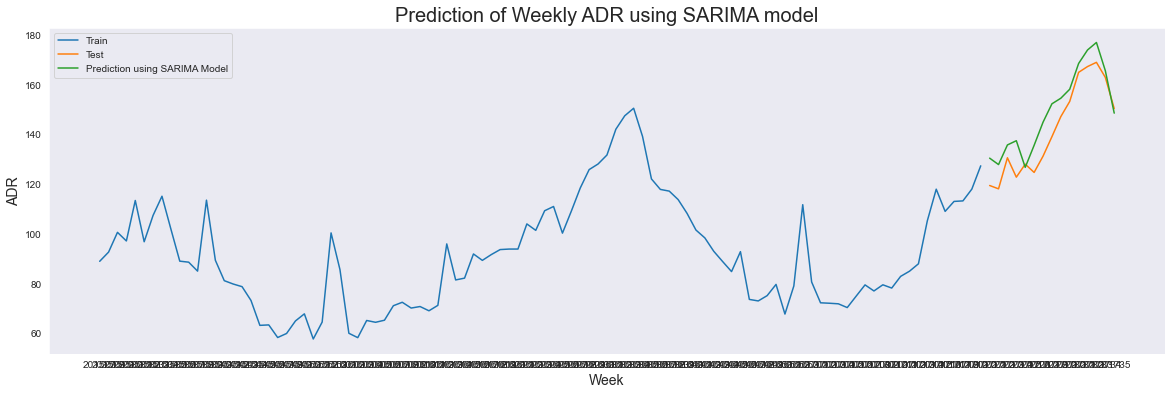

In [40]:
# Predicting the test values using predict function.
forecast = predictions
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly ADR using SARIMA model', fontsize=20)
plt.plot(train_df, label='Train')
plt.plot(test_df, label='Test')
plt.plot(forecast, label='Prediction using SARIMA Model')
plt.legend(loc='best')
plt.xlabel('Week', fontsize=14)
plt.ylabel('ADR', fontsize=14)
plt.show()

In [41]:
# RMSE Calculation
mse = mean_squared_error(test_df, predictions)
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 8.751681


### Long Short Term Memory Networks

In [42]:
# Imports
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from numpy.random import seed
seed(1)

In [43]:
lstm_df = tseries
lstm_df=np.array(lstm_df)

In [44]:
# 80-20 Split
train_size = int(len(lstm_df) * 0.8)
val_size = len(lstm_df) - train_size
train, val = lstm_df[0:train_size,:], lstm_df[train_size:len(lstm_df),:]

In [45]:
def create_dataset(df, previous=1):
    dataX, dataY = [], []
    for i in range(len(df)-previous-1):
        a = df[i:(i+previous), 0]
        dataX.append(a)
        dataY.append(df[i + previous, 0])
    return np.array(dataX), np.array(dataY)

In [46]:
# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)

In [47]:
val = scaler.fit_transform(val)

In [48]:
# Lookback period
lookback = 5
X_train, Y_train = create_dataset(train, lookback)
X_val, Y_val = create_dataset(val, lookback)

In [49]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

In [50]:
# Generate LSTM network
model = tf.keras.Sequential()
model.add(LSTM(4, input_shape=(1, lookback)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=1, verbose=2)

# list all data in history
print(history.history.keys())

Epoch 1/100
68/68 - 0s - loss: 0.1118 - val_loss: 0.0155
Epoch 2/100
68/68 - 0s - loss: 0.0617 - val_loss: 0.0142
Epoch 3/100
68/68 - 0s - loss: 0.0405 - val_loss: 0.0205
Epoch 4/100
68/68 - 0s - loss: 0.0326 - val_loss: 0.0232
Epoch 5/100
68/68 - 0s - loss: 0.0294 - val_loss: 0.0247
Epoch 6/100
68/68 - 0s - loss: 0.0275 - val_loss: 0.0238
Epoch 7/100
68/68 - 0s - loss: 0.0260 - val_loss: 0.0230
Epoch 8/100
68/68 - 0s - loss: 0.0248 - val_loss: 0.0220
Epoch 9/100
68/68 - 0s - loss: 0.0236 - val_loss: 0.0222
Epoch 10/100
68/68 - 0s - loss: 0.0225 - val_loss: 0.0201
Epoch 11/100
68/68 - 0s - loss: 0.0221 - val_loss: 0.0201
Epoch 12/100
68/68 - 0s - loss: 0.0211 - val_loss: 0.0198
Epoch 13/100
68/68 - 0s - loss: 0.0203 - val_loss: 0.0190
Epoch 14/100
68/68 - 0s - loss: 0.0198 - val_loss: 0.0180
Epoch 15/100
68/68 - 0s - loss: 0.0194 - val_loss: 0.0180
Epoch 16/100
68/68 - 0s - loss: 0.0190 - val_loss: 0.0178
Epoch 17/100
68/68 - 0s - loss: 0.0188 - val_loss: 0.0173
Epoch 18/100
68/68 - 0s

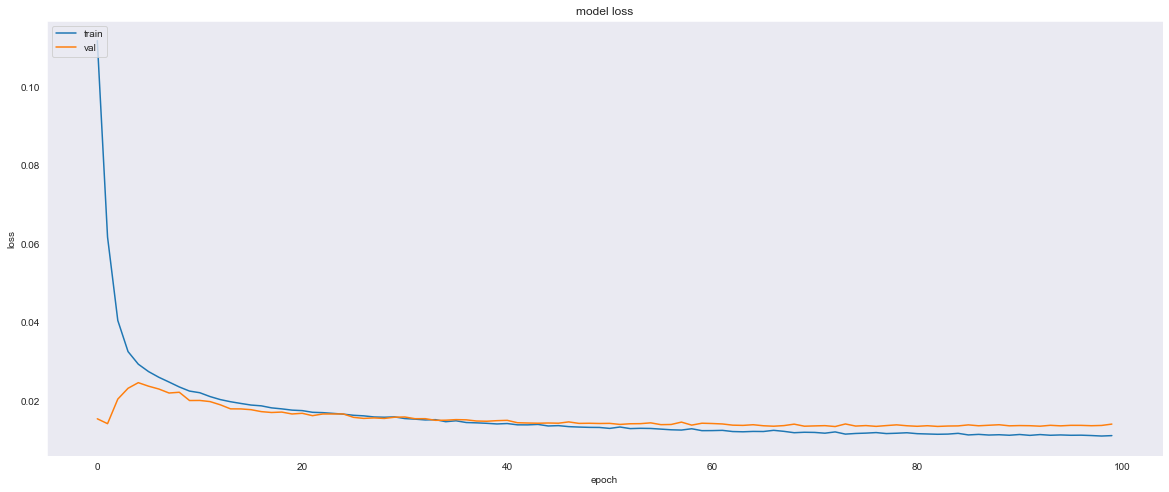

In [51]:
# summarize history for accuracy
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [52]:
# Generate predictions
trainpred = model.predict(X_train)
valpred = model.predict(X_val)

In [53]:
# Convert predictions back to normal values
trainpred = scaler.inverse_transform(trainpred)
Y_train = scaler.inverse_transform([Y_train])
valpred = scaler.inverse_transform(valpred)
Y_val = scaler.inverse_transform([Y_val])
predictions = valpred

In [54]:
# calculate RMSE
trainScore = math.sqrt(mean_squared_error(Y_train[0], trainpred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(Y_val[0], valpred[:,0]))
print('Validation Score: %.2f RMSE' % (valScore))

Train Score: 8.74 RMSE
Validation Score: 7.51 RMSE


In [55]:
# Train predictions
trainpredPlot = np.empty_like(lstm_df)
trainpredPlot[:, :] = np.nan
trainpredPlot[lookback:len(trainpred)+lookback, :] = trainpred

In [56]:
# Validation predictions
valpredPlot = np.empty_like(lstm_df)
valpredPlot[:, :] = np.nan
valpredPlot[len(trainpred)+(lookback*2)+1:len(lstm_df)-1, :] = valpred

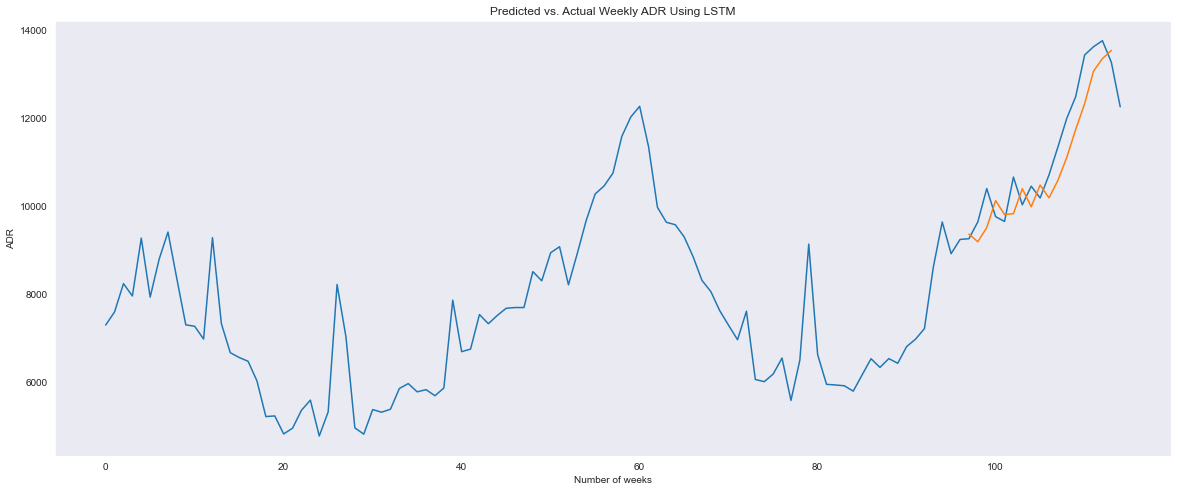

In [57]:
# Plot all predictions
plt.figure(figsize=(20,8))
inversetransform, =plt.plot(scaler.inverse_transform(lstm_df))
valpred, =plt.plot(scaler.inverse_transform(valpredPlot))
plt.xlabel('Number of weeks')
plt.ylabel('ADR')
plt.title("Predicted vs. Actual Weekly ADR Using LSTM")
plt.show()

## Classification Analysis

In [58]:
from datetime import timedelta
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [59]:
# Encoding the categorical values
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)


    print("##################### Types #####################")
    print(dataframe.dtypes)

    print("##################### Head #####################")
    print(dataframe.head(head))

    print("##################### Tail #####################")
    print(dataframe.tail(head))

    print("##################### NA #####################")
    print(dataframe.isnull().sum())

    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [60]:
# Displaying the attributes of the DataFrame
check_df(df)

##################### Shape #####################
(119390, 31)
##################### Types #####################
hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number           object
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booki

In [61]:
# Feature Engineering
filter = (df.children == 0) & (df.adults == 0) & (df.babies == 0)
df = df[~filter]
df.drop(columns=['reservation_status', 'agent'], axis=1, inplace=True)
df.dropna(subset=['country', 'children'], axis=0, inplace=True)
df.drop(df[df['adr'] < 0].index, inplace=True, axis=0)

In [62]:
df[df['distribution_channel'] == 'Undefined']
df.drop(df[df['distribution_channel'] == 'Undefined'].index, inplace=True, axis=0)

In [63]:
# Assigning new features while dropping off old ones
def family(data):
    if ((data['adults'] > 0) & (data['children'] > 0)):
        val = 1
    elif ((data['adults'] > 0) & (data['babies'] > 0)):
        val = 1
    else:
        val = 0
    return val

df['new_is_family'] = df.apply(family, axis=1)


df.drop(df[df.assigned_room_type == 'L'].index, inplace=True)
df.drop(df[df.reserved_room_type == 'L'].index, inplace=True)


unique_room_list = list(df.groupby(by='assigned_room_type').agg({'adr': 'mean'}).sort_values(by='adr', ascending=False).index)
mapper = {}
k = 10
for index, i in enumerate(unique_room_list):
    mapper[unique_room_list[index]] = k
    k = k - 1


df['assigned_room_type'].replace(mapper, inplace=True)
df['reserved_room_type'].replace(mapper, inplace=True)

df['new_room_difference'] = df['reserved_room_type'] - df['assigned_room_type']
df['new_total_people'] = df['adults'] + df['children'] + df['babies']
df['new_total_stay_day'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

from calendar import month_name
sorted_months = list(month_name)[1:]

mapper = {}
for index, i in enumerate(sorted_months):
    mapper[i] = index+1

df['new_month'] = df.arrival_date_month.replace(mapper)
df['new_month'].value_counts()
df[['new_month', 'arrival_date_month']]

df.columns
cols = ['arrival_date_day_of_month', 'new_month', 'arrival_date_year']
df['new_arrival_date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis=1)
df['new_arrival_date'].dtype
df['new_arrival_date'] = pd.to_datetime(df['new_arrival_date'])


list_PMS_date = []
for i in range(df.shape[0]):
    list_PMS_date.append(df.new_arrival_date.iloc[i] - timedelta(days=int(df.lead_time.iloc[i])))

df["new_PMS_entering_date"]=list_PMS_date
df['new_special_req_status'] = np.where(df['total_of_special_requests']!= 0, "Yes", "No")
df['new_dist_channel_type'] = np.where(df['distribution_channel']!= "Direct", "Others", "Direct")

df['new_room_difference_cat'] = np.nan
df.loc[df[df['new_room_difference'] > 0].index, 'new_room_difference_cat'] = 1
df.loc[df[df['new_room_difference'] < 0].index, 'new_room_difference_cat'] = -1
df.loc[df[df['new_room_difference'] == 0].index, 'new_room_difference_cat'] = 0

df.drop(df[(df['customer_type'] == 'Group') & (df['new_total_people'] == 1)].index, axis=0, inplace=True)

df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])
df['reservation_status_date']= df['reservation_status_date'].map(dt.datetime.toordinal)
df['new_arrival_date'] = df['new_arrival_date'].map(dt.datetime.toordinal)
df['new_PMS_entering_date'] = df['new_PMS_entering_date'].map(dt.datetime.toordinal)

df['new_is_weekend'] = np.where([(df['stays_in_weekend_nights'] > 0) & (df['stays_in_week_nights'] == 0)], 1, 0)[0]
df['new_is_weekday'] = np.where([(df['stays_in_weekend_nights'] == 0) & (df['stays_in_week_nights'] > 0)], 1, 0)[0]
df['new_is_weekend_and_weekdays'] = np.where([(df['stays_in_weekend_nights'] > 0) & (df['stays_in_week_nights'] > 0)], 1, 0)[0]
df['new_want_parking_space'] = np.where(df['required_car_parking_spaces'] > 0, 1, 0)
df['new_special_req_status'] = np.where(df['new_special_req_status'] == 'Yes', 1, 0)
df['new_adr_per_person'] = df['adr'] / (df['adults']+df['children'])
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status_date', 'new_is_family', 'new_room_difference',
       'new_total_people', 'new_total_stay_day', 'new_month',
       'new_arrival_date', 'new_PMS_entering_date', 'new_special_req_status',
       'new_dist_channel_type', 'new_room_difference_cat', 'new_is_weekend',
       'new_is_weekday', 'new_is_weekend_and_weekdays',
       'new_want_parking_space', '

In [64]:
# After new features
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number           object
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                  int64
assigned_room_type                  int64
booking_changes                     int64
deposit_type                       object
days_in_waiting_list              

In [65]:
df.shape

(119027, 44)

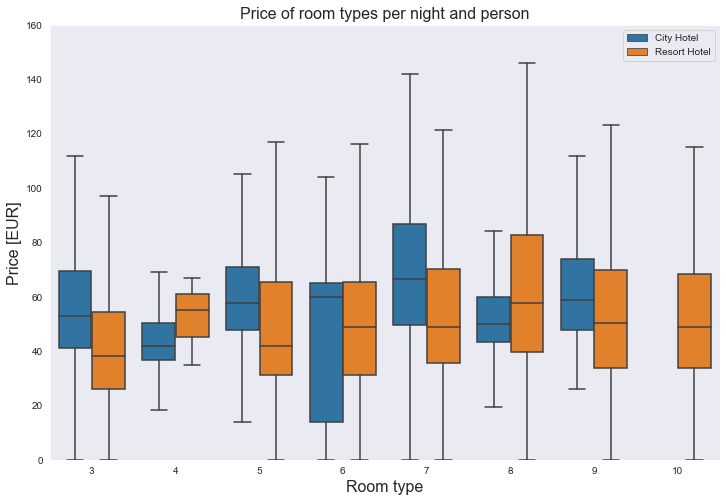

In [66]:
# normalize price per night (adr):
full_data_guests = df.loc[df["is_canceled"] == 0] # only actual guests
room_prices = full_data_guests[["hotel", "reserved_room_type", "new_adr_per_person"]].sort_values("reserved_room_type")

# boxplot:
plt.figure(figsize=(12, 8))
sns.boxplot(x="reserved_room_type",
            y="new_adr_per_person",
            hue="hotel",
            data=room_prices,
            hue_order=["City Hotel", "Resort Hotel"],
            fliersize=0)
plt.title("Price of room types per night and person", fontsize=16)
plt.xlabel("Room type", fontsize=16)
plt.ylabel("Price [EUR]", fontsize=16)
plt.legend(loc="upper right")
plt.ylim(0, 160)
plt.savefig('your_figure.png')
plt.show()

In [67]:
# Removing redundant columns
df.drop(columns=['adults', 'babies', 'children', 'total_of_special_requests'], inplace=True, axis=1)

df.drop(columns=['arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month',
                 'stays_in_weekend_nights', 'stays_in_week_nights', 'required_car_parking_spaces',
                 'distribution_channel', 'reserved_room_type', 'assigned_room_type','reservation_status_date',], axis=1, inplace=True)

df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'meal', 'country',
       'market_segment', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr', 'new_is_family',
       'new_room_difference', 'new_total_people', 'new_total_stay_day',
       'new_month', 'new_arrival_date', 'new_PMS_entering_date',
       'new_special_req_status', 'new_dist_channel_type',
       'new_room_difference_cat', 'new_is_weekend', 'new_is_weekday',
       'new_is_weekend_and_weekdays', 'new_want_parking_space',
       'new_adr_per_person'],
      dtype='object')

In [68]:
df.shape

(119027, 29)

In [69]:
# encoding
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

for col in binary_cols:
    label_encoder(df, col)

cat_cols, num_cols, cat_but_car = grab_col_names(df)
ohe_cols = [col for col in cat_cols if 12 >= df[col].nunique() > 2]
ohe_cols.remove('new_room_difference_cat')
df = one_hot_encoder(df, ohe_cols, drop_first=True)

le = LabelEncoder()
# Label encoding for large number of classes
df['country'] = le.fit_transform(df['country'])

Observations: 119027
Variables: 29
cat_cols: 15
num_cols: 13
cat_but_car: 1
num_but_cat: 11


In [70]:
# Scaler
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head(10)

,hotel,is_canceled,lead_time,country,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,...,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,1,0,2.225178,135,0,-0.103155,-0.09058,4.356980,-0.131955,-2.023048,...,0,1,0,0,0,0,0,0,1,0
1,1,0,5.921388,135,0,-0.103155,-0.09058,5.923468,-0.131955,-2.023048,...,0,1,0,0,0,0,0,0,1,0
2,1,0,-0.909583,59,0,-0.103155,-0.09058,-0.342483,-0.131955,-0.535800,...,0,1,0,0,0,0,0,0,1,0
3,1,0,-0.853438,59,0,-0.103155,-0.09058,-0.342483,-0.131955,-0.535800,...,1,0,0,0,0,0,0,0,1,0
4,1,0,-0.844081,59,0,-0.103155,-0.09058,-0.342483,-0.131955,-0.079710,...,0,0,0,0,1,0,0,0,1,0
5,1,0,-0.844081,59,0,-0.103155,-0.09058,-0.342483,-0.131955,-0.079710,...,0,0,0,0,1,0,0,0,1,0
6,1,0,-0.975086,135,0,-0.103155,-0.09058,-0.342483,-0.131955,0.098760,...,0,1,0,0,0,0,0,0,1,0
7,1,0,-0.890868,135,0,-0.103155,-0.09058,-0.342483,-0.131955,0.019440,...,0,1,0,0,0,0,0,0,1,0
8,1,1,-0.179699,135,0,-0.103155,-0.09058,-0.342483,-0.131955,-0.396990,...,0,0,0,0,1,0,0,0,1,0
9,1,1,-0.273273,135,0,-0.103155,-0.09058,-0.342483,-0.131955,0.069015,...,0,0,0,1,0,0,0,0,1,0


# Model Building

In [71]:
# Setting 
X = df.drop(['is_canceled'], axis=1)
y = df['is_canceled']

In [72]:
# RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

In [73]:
# Set of models being tried
models = [('KNN', KNeighborsClassifier()),
          ("CART", DecisionTreeClassifier()),
          ("RF", RandomForestClassifier()),
          ('Adaboost', AdaBoostClassifier()),
          ('GBM', GradientBoostingClassifier()),
          ('LightGBM', LGBMClassifier())
          ]


In [74]:
# List of parameters from which best selection is to be made
knn_params = {"n_neighbors": [2, 10, 20, 40, 50]}

cart_params = {'max_depth': [1, 5, 10, 15, 20],
               "min_samples_split": [2, 5, 10, 15, 30]}

rf_params = {"max_depth": [5, 8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [2, 8, 15, 20],
             "n_estimators": [100, 200, 500, 1000]}

ada_params = {
    'n_estimators': [2, 10, 15, 20],
    'learning_rate': [(0.97 + x / 100) for x in range(0, 8)],
    'algorithm': ['SAMME', 'SAMME.R']}

gbm_params = {"learning_rate": [0.01, 0.1],
              "n_estimators": [100, 300, 500, 1500],
              "min_samples_split": [2, 8, 15, 20]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [100, 300, 500, 1500],
                   "colsample_bytree": [0.5, 0.7, 1]}

In [75]:
randomcv_models = [('KNN', KNeighborsClassifier(), knn_params),
                   ("CART", DecisionTreeClassifier(), cart_params),
                   ("RF", RandomForestClassifier(), rf_params),
                   ('Adaboost', AdaBoostClassifier(), ada_params),
                   ('GBM', GradientBoostingClassifier(), gbm_params),
                   ('LightGBM', LGBMClassifier(), lightgbm_params)
                   ]

In [76]:
# Search for best hyperparameters
name_param = {}
for name, model, params in randomcv_models:
    rf_random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1)
    rf_random.fit(X, y)
    name_param[name] = rf_random.best_params_

for name in name_param:
    print(f'#################################### Best Params for {name} ####################################')
    print(name_param[name])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/Users/pranshusrivastav/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 5 is smaller than n_iter=100. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/pranshusrivastav/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 25 is smaller than n_iter=100. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/pranshusrivastav/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 64 is smaller than n_iter=100. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 64 candidates, totalling 192 fits


/Users/pranshusrivastav/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 32 is smaller than n_iter=100. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 32 candidates, totalling 96 fits


/Users/pranshusrivastav/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 24 candidates, totalling 72 fits
#################################### Best Params for KNN ####################################
{'n_neighbors': 50}
#################################### Best Params for CART ####################################
{'min_samples_split': 2, 'max_depth': 1}
#################################### Best Params for RF ####################################
{'n_estimators': 200, 'min_samples_split': 8, 'max_features': 5, 'max_depth': 5}
#################################### Best Params for Adaboost ####################################
{'n_estimators': 10, 'learning_rate': 0.98, 'algorithm': 'SAMME'}
#################################### Best Params for GBM ####################################
{'n_estimators': 100, 'min_samples_split': 8, 'learning_rate': 0.01}
#################################### Best Params for LightGBM ####################################
{'n_estimators': 100, 'learning_rate': 0.01, 'colsample_bytree': 1}


### Model Fitting

In [77]:
knn_model= KNeighborsClassifier(n_neighbors= 50)
knn_model.fit(X, y)
cv_results = cross_validate(knn_model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])

In [78]:
cv_results['test_roc_auc'].mean()

0.667655174437105

In [79]:
cv_results['test_f1'].mean()

0.4783692328818027

In [80]:
cv_results['test_accuracy'].mean()

0.6208911189398797

In [81]:
cart_model= DecisionTreeClassifier(min_samples_split= 2, max_depth =1)
cart_model.fit(X, y)
cv_results = cross_validate(cart_model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])

In [82]:
cv_results['test_roc_auc'].mean()

0.6634086274594935

In [83]:
cv_results['test_f1'].mean()

0.4775845436850178

In [84]:
cv_results['test_accuracy'].mean()

0.7498056893062083

In [85]:
rf_model = RandomForestClassifier(n_estimators = 100, min_samples_split= 20, min_samples_leaf= 4, max_features= 5, max_depth=5,random_state=17)
rf_model.fit(X, y)
cv_results = cross_validate(rf_model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])

In [86]:
cv_results['test_roc_auc'].mean()

0.8346988274940991

In [87]:
cv_results['test_f1'].mean()

0.49450099017468363

In [88]:
cv_results['test_accuracy'].mean()

0.748200986174117

In [89]:
ada_model= AdaBoostClassifier(n_estimators =10, learning_rate= 0.98, algorithm = 'SAMME')
ada_model.fit(X, y)
cv_results = cross_validate(ada_model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])

In [90]:
cv_results['test_roc_auc'].mean()

0.8450887568995696

In [91]:
cv_results['test_f1'].mean()

0.587526172586169

In [92]:
cv_results['test_accuracy'].mean()

0.7551911086638504

In [93]:
gbm_model= GradientBoostingClassifier(n_estimators = 100, min_samples_split= 2, learning_rate = 0.01)
gbm_model.fit(X, y)
cv_results = cross_validate(gbm_model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])

In [94]:
cv_results['test_roc_auc'].mean()

0.8504363401535899

In [95]:
cv_results['test_f1'].mean()

0.48827528692086536

In [96]:
cv_results['test_accuracy'].mean()

0.7525446958218376

In [97]:
light_gbm_model= LGBMClassifier(n_estimators = 100, learning_rate= 0.01, colsample_bytree = 1)
light_gbm_model.fit(X, y)
cv_results = cross_validate(light_gbm_model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])

In [98]:
cv_results['test_roc_auc'].mean()

0.7896457111470084

In [99]:
cv_results['test_f1'].mean()

0.5606711414312333

In [100]:
cv_results['test_accuracy'].mean()

0.6985362799246297

### Model Evaluation

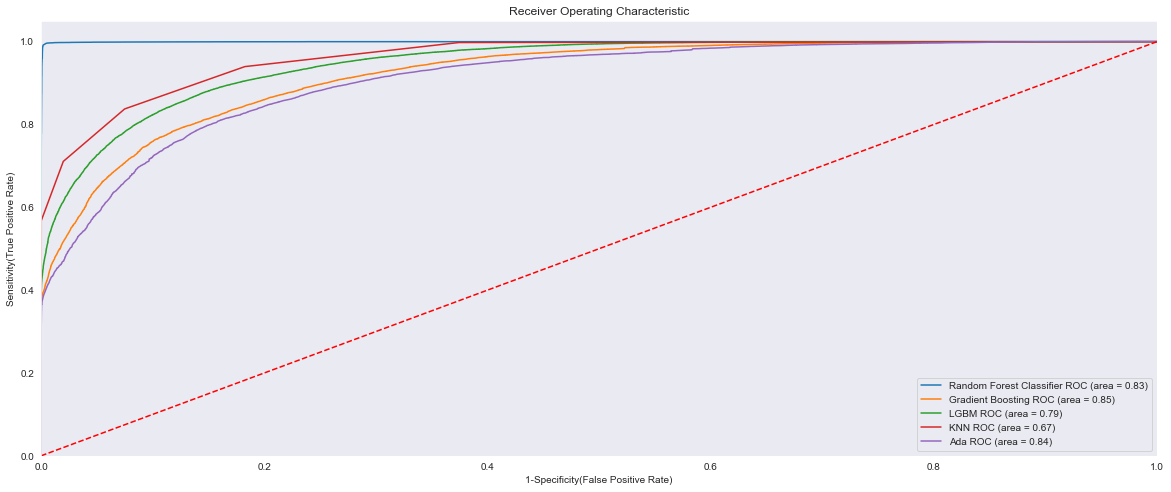

In [101]:
plt.figure(figsize=(20,8))

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Random Forest Classifier',
    'model': RandomForestClassifier(),
    'auc': 0.8347
},
{
    'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(),
    'auc': 0.8504
},
{
    'label': 'LGBM',
    'model': LGBMClassifier(),
    'auc': 0.7895
},
{
    'label': 'KNN',
    'model': KNeighborsClassifier(),
    'auc': 0.6676
},
{
    'label': 'Ada',
    'model': AdaBoostClassifier(),
    'auc': 0.8450
},
    
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X, y) # train the model
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])
# Calculate Area under the curve to display on the plot
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], m['auc']))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()  

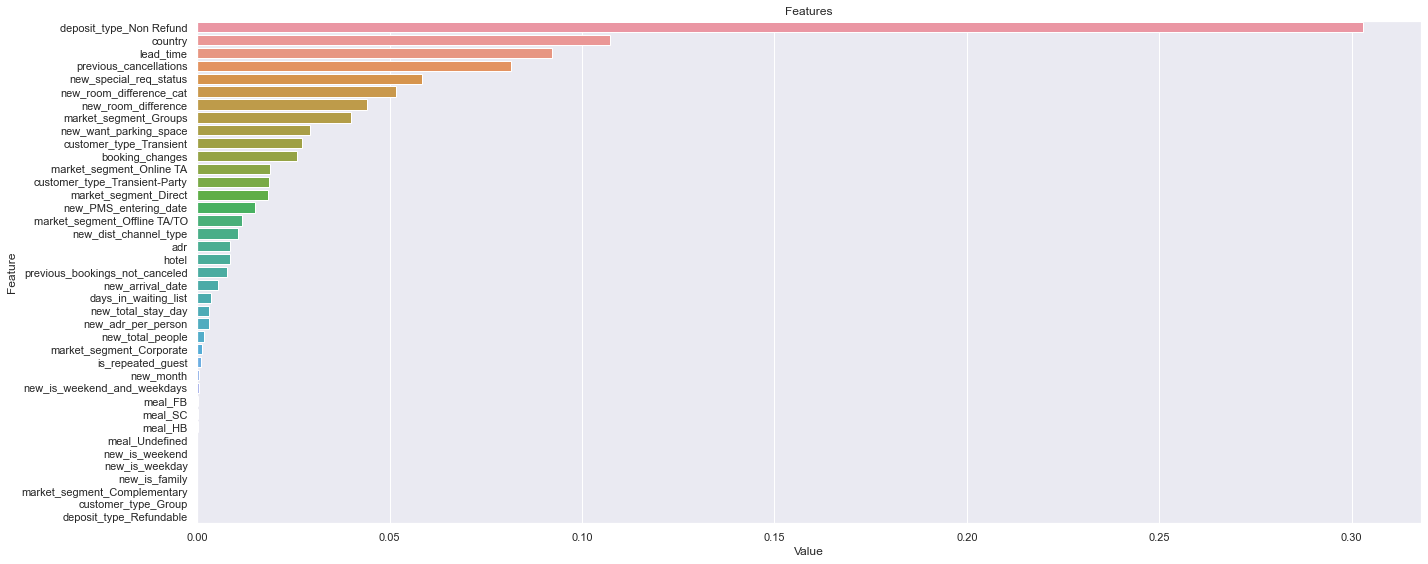

In [102]:

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(20, 8))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X)

In [103]:
test_df

,ADR
FullDate,
201721,119.450999
201722,118.106380
201723,130.592753
201724,122.793344
201725,128.033632
201726,124.700541
201727,131.224835
201728,139.069055
201729,147.137428


## Combination of both approaches

In [ ]:
test_data = c[(c.arrival_date_week_number >= '21') & (c.arrival_date_year >= 2017)]

In [ ]:
new_test = df[df.index.isin(test_data.index)]

In [ ]:
new_X = new_test.drop(['is_canceled'], axis=1)
new_y = new_test['is_canceled']

In [107]:
p = ada_model.predict(new_X)

In [108]:
new_test['Predictions'] = p

<ipython-input-108-93d48279de3a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_test['Predictions'] = p


In [109]:
new_test['accurate'] = new_test['is_canceled'] == new_test['Predictions']

<ipython-input-109-94b157169141>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_test['accurate'] = new_test['is_canceled'] == new_test['Predictions']


In [110]:
new_test['accurate'].value_counts()

True     12818
False     5211
Name: accurate, dtype: int64

In [111]:
new_test['Predictions'].value_counts()

0    13855
1     4174
Name: Predictions, dtype: int64